In [6]:
import scipy.io as scio
import h5py
import tifffile as tf
from PIL import Image

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import networkx as nx
from networkx.algorithms import community
import powerlaw

from scipy import stats
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from itertools import chain

## Settings and Parameters

In [23]:
region_names = {64: 'MBPED',65: 'MBVL',66: 'MBML',55: 'LH',72: 'SLP',73: 'SIP',74: 'SMP',63: 'CRE',84: 'SCL',59: 'ICL',
                4: 'NO',23: 'EB',26: 'FB',56: 'LAL',79: 'AOTU',75: 'AVLP',76: 'PVLP',77: 'IVLP',60: 'VES',80: 'GOR',82: 'SPS',
                85: 'EPA',67: 'FLA'}
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]

## path
path ="../result/"

## Generate average G7f network over 20 flies

outpath: /0-LLB/New_data/data_analysis_res_deepcad/Ach-all-flies-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230417-fly2-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230420-fly2-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230420-fly3-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230428-fly1-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230507-fly1-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230510-fly1-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230510-fly2-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230511-fly2-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230511-fly3-pre_stimu/
---- processing inputpath:  /0-LL

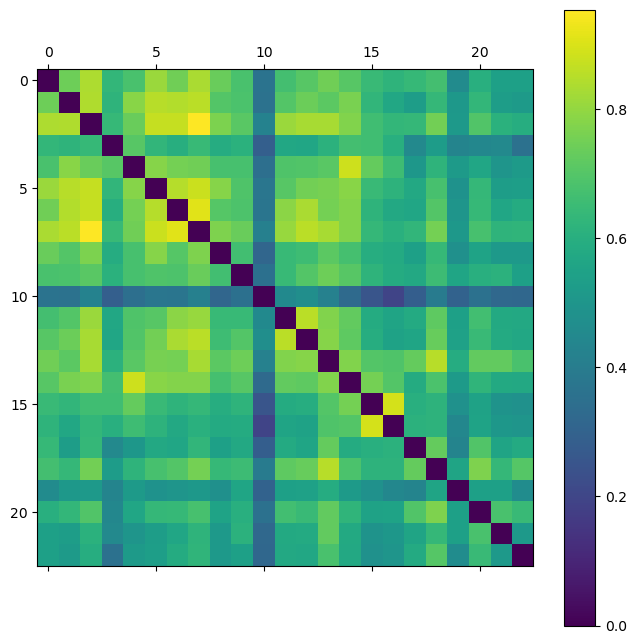

---- Finish saving similarity matrix!


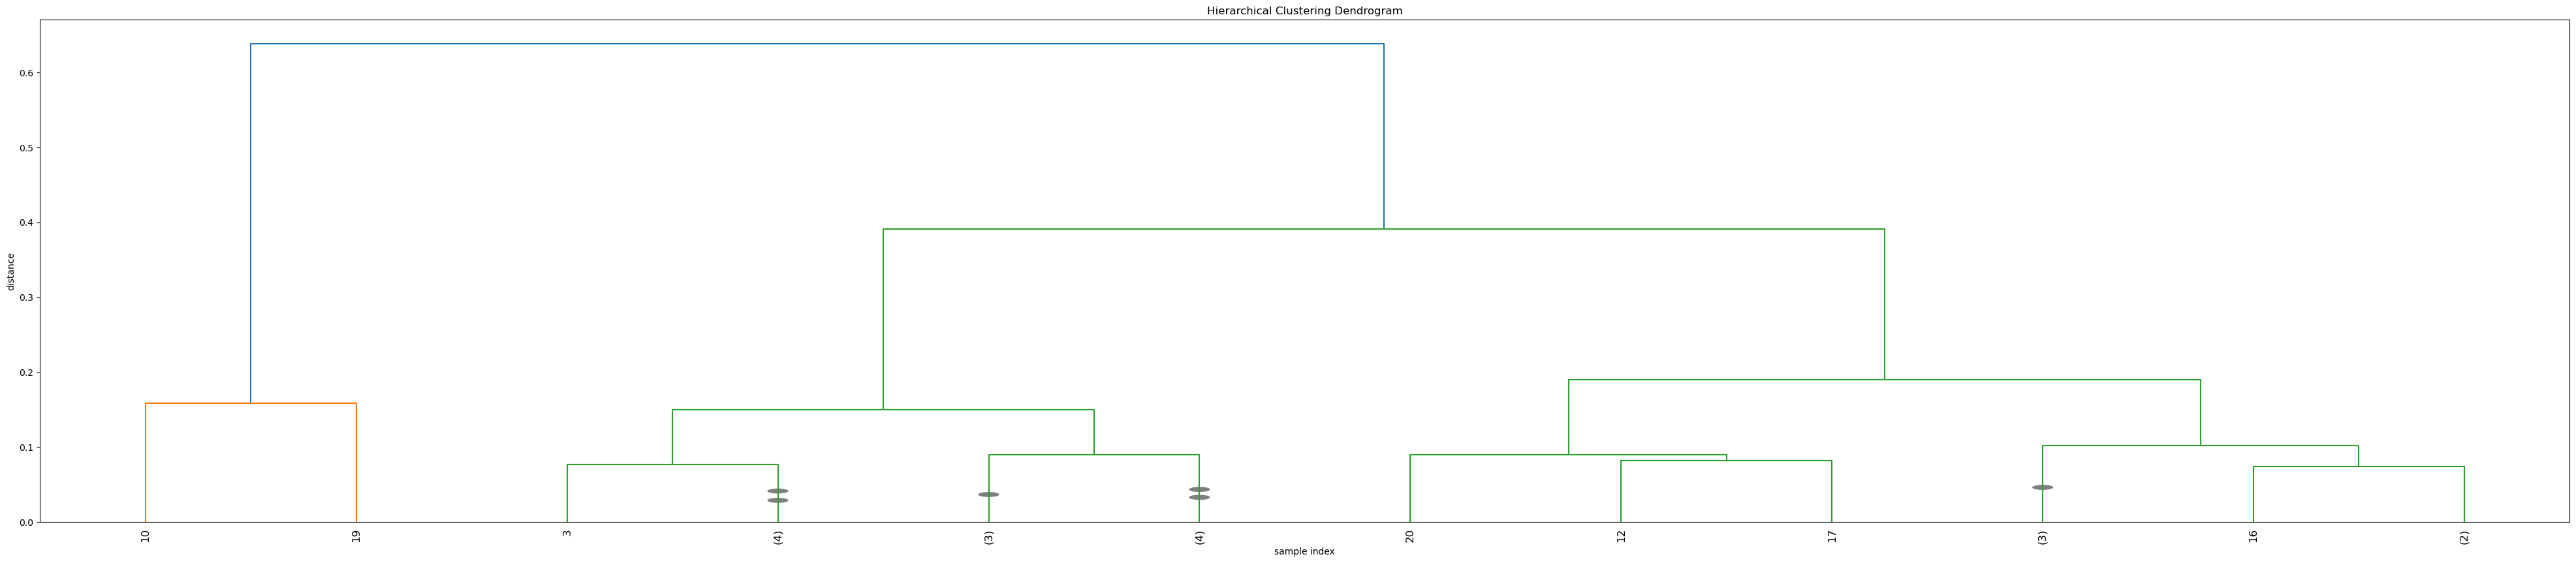

clusters: <class 'numpy.ndarray'> 23 [2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2]
hierarchy region name: 23 ['NO', 'GOR', 'MBPED', 'MBVL', 'MBML', 'LH', 'SLP', 'SIP', 'SMP', 'CRE', 'SCL', 'ICL', 'EB', 'FB', 'LAL', 'AOTU', 'AVLP', 'PVLP', 'IVLP', 'VES', 'SPS', 'EPA', 'FLA']
hierarchy similarity: (23, 23)


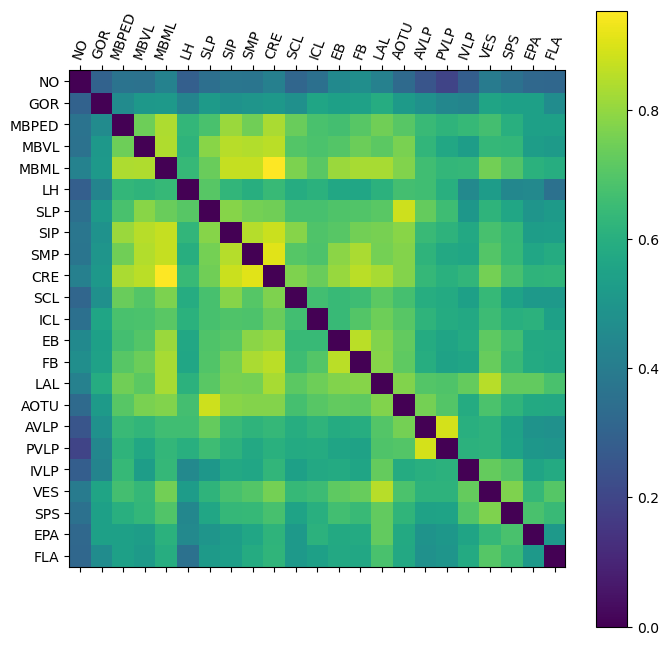

---- Finish saving hierarchy similarity matrix!
END


In [24]:
''' generate average correlation matrix '''

## parameters
len_max = 400

## output path
outpath = path + 'G7f_average_RS/'
print("outpath:", outpath)

'''
initialization
'''

n_regions = len(focus_regions_0)
region_similarity_dict = {}
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        region_similarity_dict[(focus_regions_0[i],focus_regions_0[j])] = []
region_records_avg_dict = {}
for i in range(n_regions):
    region_records_avg_dict[focus_regions_0[i]] = []
    
'''
process ACh flies
'''

data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                   '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # all brain regions
focus_regions_1 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 80,82,
focus_regions_2 = [64,65,66,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 55,80,82,

for fly_idx in data_index_list:
    inputpath = path + 'flies_ACh/Ach-' + fly_idx + '-pre_stimu/'
    print("---- processing inputpath: ", inputpath)
    
    region_records_avg = []
    focus_regions = []
    if fly_idx == '20230428-fly1' or fly_idx == '20230510-fly1':
        focus_regions = focus_regions_1
    elif fly_idx == '20230507-fly1':
        focus_regions = focus_regions_2
    else:
        focus_regions = focus_regions_0

    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        pre_sti = records[:, 4:len_max - 4]    

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        
        region_records_avg.append(pre_sti_avg)
        region_records_avg_dict[region_idx].append(pre_sti_avg)

    ## calculate pearson correlation
    n_regions_new = len(focus_regions)
    for i in range(n_regions_new - 1):
        for j in range(i + 1, n_regions_new):   
            pearson = pearsonr(region_records_avg[i], region_records_avg[j])
            pair = (focus_regions[i], focus_regions[j])
            region_similarity_dict[pair].append(pearson[0])

'''
process 5HT flies
'''

data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # all brain regions
focus_regions_1 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,85,67] # brain regions except 82
focus_regions_2 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 80, 82
focus_regions_3 = [64,65,66,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # brain regions except 55

for fly_idx in data_index_list:
    inputpath = path + 'flies_5HT/' + fly_idx + '-pre_stimu/'
    print("---- processing inputpath: ", inputpath)
 
    region_records_avg = []
    focus_regions = []
    if fly_idx in ["20230429-r5HT1.0-fly1", "20230516-r5HT1.0-fly4"]:
        focus_regions = focus_regions_1
    elif fly_idx in ["20230601-r5HT1.0-fly3", "20230517-r5HT1.0-fly1"]:
        focus_regions = focus_regions_2
    elif fly_idx == "20230601-r5HT1.0-fly1":
        focus_regions = focus_regions_3
    else:
        focus_regions = focus_regions_0

    for region_idx in focus_regions:   
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        pre_sti = records[:, 4:len_max - 4]  

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)

        region_records_avg.append(pre_sti_avg)
        region_records_avg_dict[region_idx].append(pre_sti_avg)

    ## calculate pearson correlation
    n_regions_new = len(focus_regions)
    for i in range(n_regions_new - 1):
        for j in range(i + 1, n_regions_new):   
            pearson = pearsonr(region_records_avg[i], region_records_avg[j])
            pair = (focus_regions[i], focus_regions[j])
            region_similarity_dict[pair].append(pearson[0])

'''
generate correlation matrix
'''

## calculate correlation
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[(focus_regions_0[i],focus_regions_0[j])])
print("similarity:", similarity.shape)
np.save(outpath + 'whole_brain_all_regions_similarity_ACH_5HT.npy', similarity)
   
## plot correlation matrix
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.savefig(outpath + 'whole_brain_all_regions_similarity_ACH_5HT.png', dpi = 300, bbox_inches='tight')
plt.show()
print("---- Finish saving similarity matrix!")


'''
calculate hierarchy clustering
'''
region_records_avg_list = []
for i in range(n_regions):
    records_avg = np.mean(region_records_avg_dict[focus_regions_0[i]], axis = 0)
    region_records_avg_list.append(records_avg) 
Z = linkage(region_records_avg_list, 'ward') 
plt.figure(figsize=(50, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()

## clusters
k = 2
clusters = fcluster(Z, k, criterion='maxclust')
print("clusters:", type(clusters), len(clusters), clusters)    
list(enumerate(clusters))
hierarchy_idx = []
hierarchy_region = []
for index_id in range(1,k+1):
    index = [i for i,j in enumerate(clusters) if j == index_id]
    hierarchy_idx.append(index)   
    hierarchy_region += list(np.array(focus_regions_0)[index])

# hierarchy orders
hierarchy_region_name = []
for i in hierarchy_region:
    hierarchy_region_name.append(region_names[i])
hierarchy_idx_list = list(chain(*hierarchy_idx))
print("hierarchy region name:", len(hierarchy_region_name), hierarchy_region_name)

# calculate hierarchy correlation
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        pair = (hierarchy_region[i],hierarchy_region[j])
        if pair not in region_similarity_dict.keys():
            pair = (hierarchy_region[j],hierarchy_region[i])
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])
print("hierarchy similarity:", similarity.shape)

## plot hierarchy correlation matrix
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.xticks(rotation = 70)
plt.xticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.yticks(rotation = 0)
plt.yticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.savefig(outpath + 'whole_brain_all_regions_similarity_hierarchy1_ACH_5HT.png', dpi = 300, bbox_inches='tight')
plt.show()
print("---- Finish saving hierarchy similarity matrix!")

hierarchy_idx_dict = {}
for k in range(len(hierarchy_idx)):
    hierarchy_idx_dict[k] = hierarchy_idx[k]
np.save(outpath + 'whole_brain_all_regions_similarity_hierarchy1_ACH_5HT_idx.npy', hierarchy_idx_dict)
np.save(outpath + 'whole_brain_all_regions_similarity_hierarchy1_ACH_5HT.npy', similarity)

print("END")

In [25]:
''' generate average network and communities '''

## parameters
delete_seg = 0

'''
generate networks
'''

## load data
load_path = path + 'G7f_average_RS/'
similarity = np.load(load_path + 'whole_brain_all_regions_similarity_ACH_5HT.npy')
print("similarity:", similarity.shape)

## collect nodes and edges
n_neurons = len(similarity)
nodes = [i for i in range(n_neurons)]
edges = {}
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):   
        edges[(i,j)] = similarity[i,j]
        
## keep only correlations with high positive values 
weighted_edges_list = []
for v in edges.values():
    weighted_edges_list.append(v)
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
source, target, weight = [], [], []
selected_edges = []
for k,v in edges.items():
    if np.mean(v) < threshold:
        continue
    source.append(int(k[0]))
    target.append(int(k[1]))
    weight.append(np.round(v,4))
    selected_edges.append((int(k[0]), int(k[1]), np.round(v,4)))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(load_path + 'regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_ACH_5HT.csv', index=False)

print("END")

similarity: (23, 23)
END


/0-LLB/New_data/data_analysis_res_deepcad/Ach-all-flies-pre_stimu/


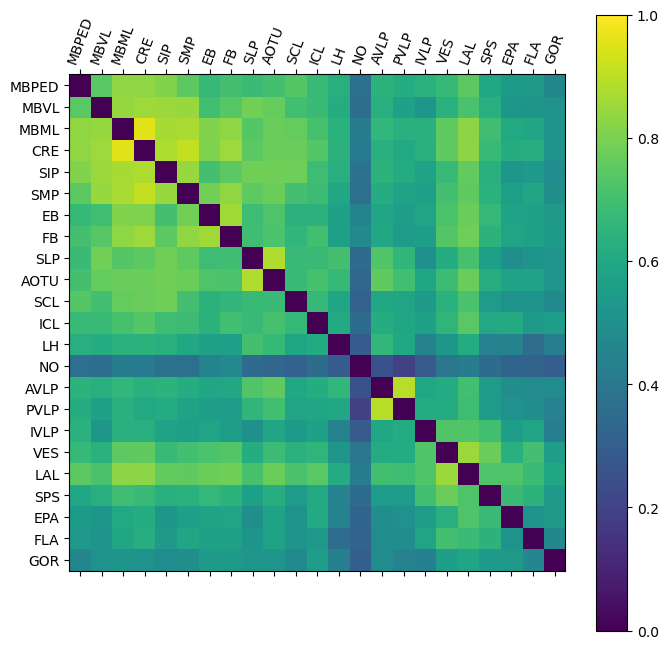

END


In [26]:
''' plot matrix according to community division '''

load_path = path + 'G7f_average_RS/'
print(load_path)

## region orders according to community division
hierarchy_region = [64, 65, 66, 63,  73, 74, 23, 26, 72, 79,  84, 59, 55, 4, 75, 76, 77, 60, 56, 82, 85, 67, 80]
hierarchy_region_name = ['MBPED', 'MBVL', 'MBML', 'CRE', 'SIP', 'SMP', 'EB', 'FB', 'SLP', 'AOTU', 'SCL', 'ICL', 
                         'LH', 'NO', 'AVLP', 'PVLP', 'IVLP', 'VES', 'LAL',  'SPS', 'EPA', 'FLA', 'GOR']

## calculate correlation matrix according to community division
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        pair = (hierarchy_region[i],hierarchy_region[j])
        if pair not in region_similarity_dict.keys():
            pair = (hierarchy_region[j],hierarchy_region[i])
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])

## plot correlation matrix according to community division
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 1) 
figure.colorbar(caxes) 
plt.xticks(rotation = 70)
plt.xticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.yticks(rotation = 0)
plt.yticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.savefig(load_path + 'whole_brain_all_regions_similarity_hierarchy2_ACH_5HT.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(load_path + 'whole_brain_all_regions_similarity_hierarchy2_ACH_5HT_region.npy', hierarchy_region)
np.save(load_path + 'whole_brain_all_regions_similarity_hierarchy2_ACH_5HT.npy', similarity)

print("END")

## Generate average ACh network over 10 ACh-flies

outpath: /0-LLB/New_data/data_analysis_res_deepcad/Ach-all-flies-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230417-fly2-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230420-fly2-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230420-fly3-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230428-fly1-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230507-fly1-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230510-fly1-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230510-fly2-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-20230511-fly2-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/Ach-2023

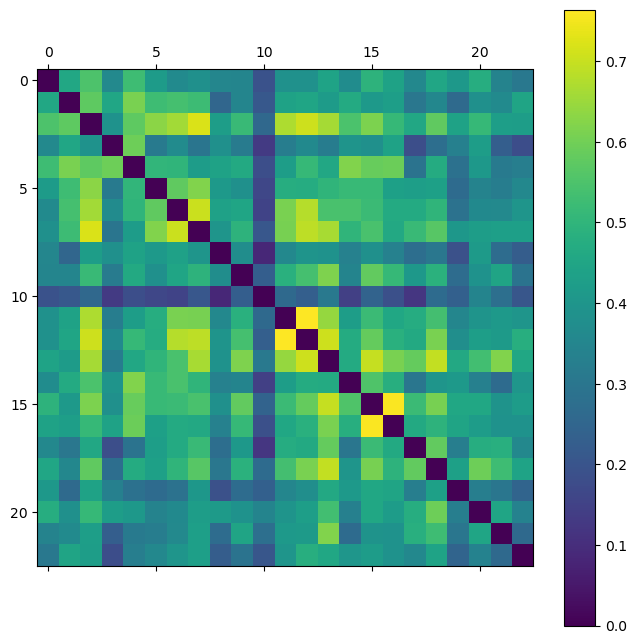

---- Finish saving similarity matrix!


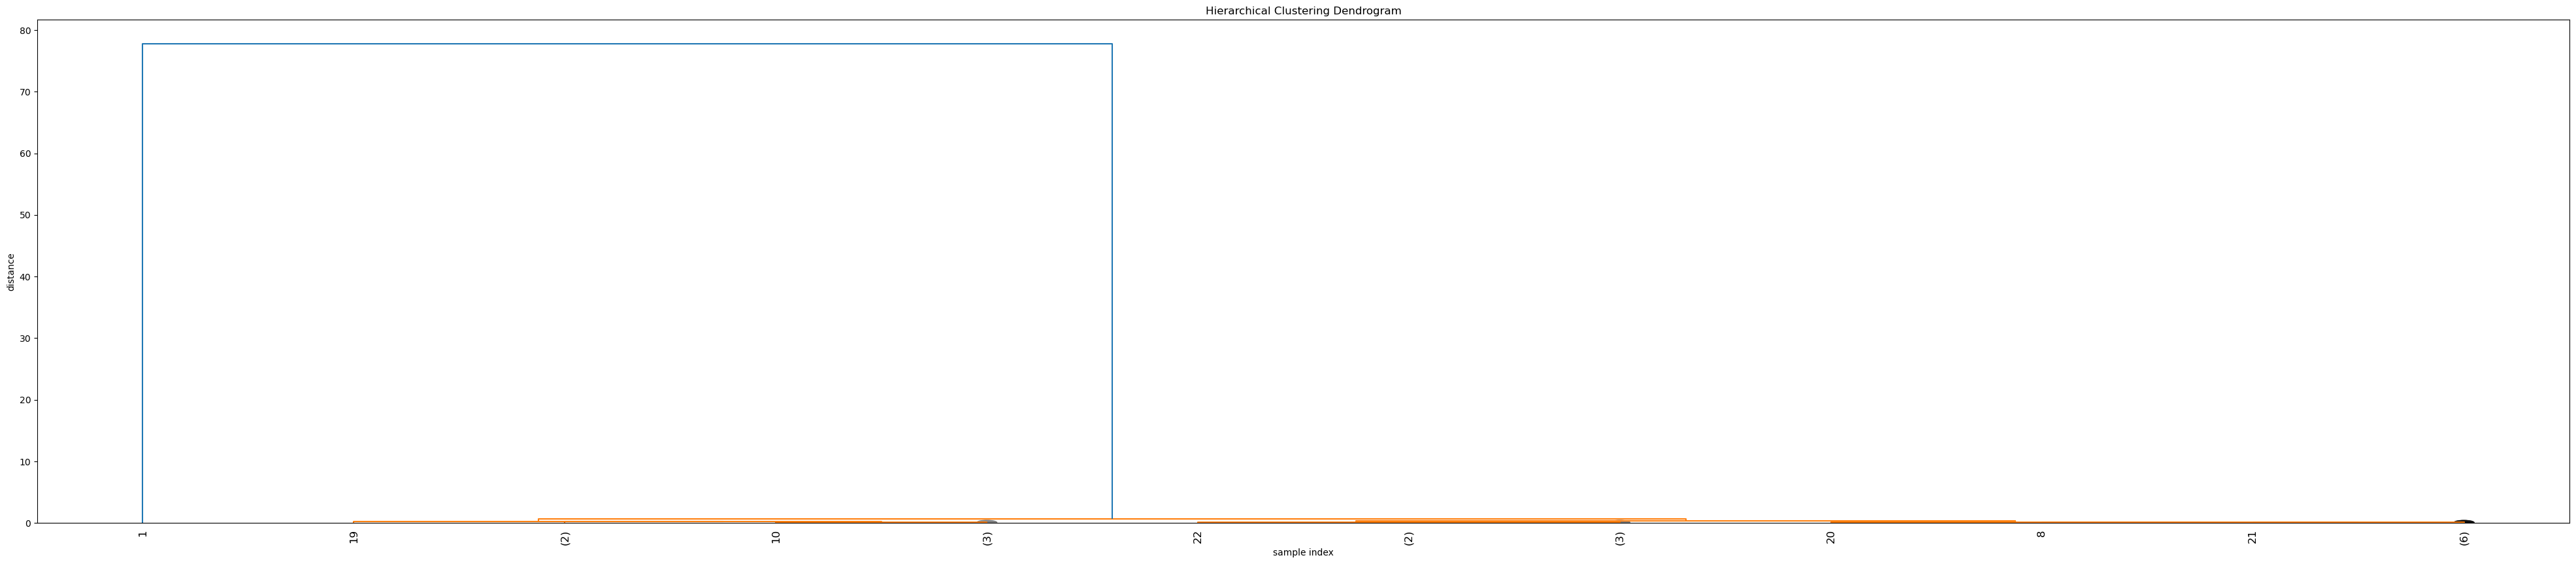

clusters: <class 'numpy.ndarray'> 23 [1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
hierarchy region name: 23 ['MBPED', 'MBML', 'LH', 'SLP', 'SIP', 'SMP', 'CRE', 'SCL', 'ICL', 'NO', 'EB', 'FB', 'LAL', 'AOTU', 'AVLP', 'PVLP', 'IVLP', 'VES', 'GOR', 'SPS', 'EPA', 'FLA', 'MBVL']
hierarchy similarity: (23, 23)


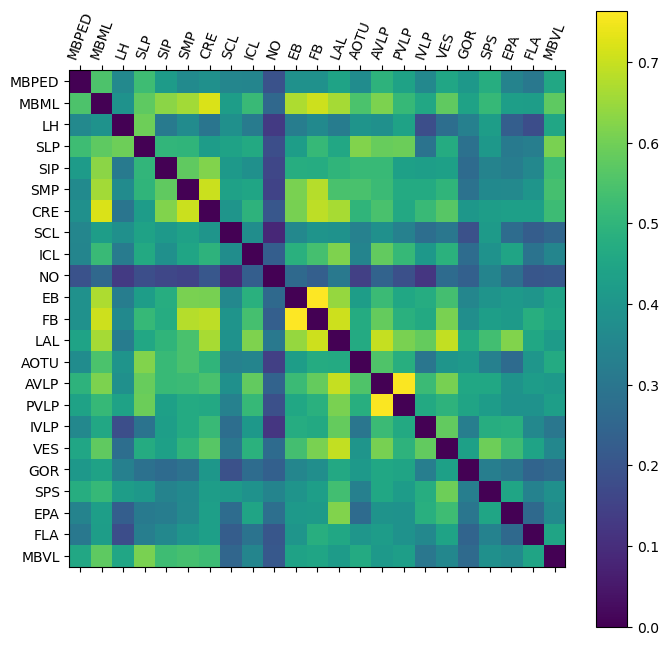

---- Finish saving hierarchy similarity matrix!
END


In [27]:
''' generate average correlation matrix '''

## output path
outpath = path + 'ACh_5HT_average_RS/'
print("outpath:", outpath)

'''
initialization
'''

n_regions = len(focus_regions_0)
region_similarity_dict = {}
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        region_similarity_dict[(focus_regions_0[i],focus_regions_0[j])] = []
region_records_avg_dict = {}
for i in range(n_regions):
    region_records_avg_dict[focus_regions_0[i]] = []
    
'''
process ACh flies
'''

data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                   '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]
focus_regions_1 = [64,66,55,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # brain regions except 65,72,73,74
focus_regions_2 = [64,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # brain regions except 65
focus_regions_3 = [64,65,66,55,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 72,80,82
focus_regions_4 = [64,65,66,73,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 55,80,82,72,74
focus_regions_5 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 80,82
focus_regions_6 = [64,65,66,55,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # brain regions except 72

for fly_idx in data_index_list:
    inputpath = path + 'flies_ACh/Ach-' + fly_idx + '-trans-pre_stimu/'
    print("---- processing inputpath: ", inputpath)
    
    region_records_avg = []
    focus_regions = []
    if fly_idx == '20230417-fly2':
        focus_regions = focus_regions_1
    elif fly_idx == '20230420-fly3':
        focus_regions = focus_regions_2
    elif fly_idx == '20230428-fly1':
        focus_regions = focus_regions_3
    elif fly_idx == '20230507-fly1':
        focus_regions = focus_regions_4
    elif fly_idx == '20230510-fly1':
        focus_regions = focus_regions_5
    elif fly_idx == '20230511-fly2':
        focus_regions = focus_regions_6
    else:
        focus_regions = focus_regions_0

    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        len_max = len(records[0])
        pre_sti = records[:, 4:len_max - 4]   

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        
        region_records_avg.append(pre_sti_avg)
        region_records_avg_dict[region_idx].append(pre_sti_avg)

    ## calculate pearson correlation
    n_regions_new = len(focus_regions)
    for i in range(n_regions_new - 1):
        for j in range(i + 1, n_regions_new):   
            pearson = pearsonr(region_records_avg[i], region_records_avg[j])
            pair = (focus_regions[i], focus_regions[j])
            region_similarity_dict[pair].append(pearson[0])

'''
generate correlation matrix
'''

## calculate correlation
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[(focus_regions_0[i],focus_regions_0[j])])
print("similarity:", similarity.shape)
np.save(outpath + 'whole_brain_all_regions_similarity_ACH.npy', similarity)
   
## plot correlation matrix
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.savefig(outpath + 'whole_brain_all_regions_similarity_ACH.png', dpi = 300, bbox_inches='tight')
plt.show()
print("---- Finish saving similarity matrix!")


'''
calculate hierarchy clustering
'''
region_records_avg_list = []
for i in range(n_regions):
    records_avg = np.mean(region_records_avg_dict[focus_regions_0[i]], axis = 0)
    region_records_avg_list.append(records_avg) 
Z = linkage(region_records_avg_list, 'ward') 
plt.figure(figsize=(50, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()

## clusters
k = 2
clusters = fcluster(Z, k, criterion='maxclust')
print("clusters:", type(clusters), len(clusters), clusters)    
list(enumerate(clusters))
hierarchy_idx = []
hierarchy_region = []
for index_id in range(1,k+1):
    index = [i for i,j in enumerate(clusters) if j == index_id]
    hierarchy_idx.append(index)   
    hierarchy_region += list(np.array(focus_regions_0)[index])

# hierarchy orders
hierarchy_region_name = []
for i in hierarchy_region:
    hierarchy_region_name.append(region_names[i])
hierarchy_idx_list = list(chain(*hierarchy_idx))
print("hierarchy region name:", len(hierarchy_region_name), hierarchy_region_name)

# calculate hierarchy correlation
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        pair = (hierarchy_region[i],hierarchy_region[j])
        if pair not in region_similarity_dict.keys():
            pair = (hierarchy_region[j],hierarchy_region[i])
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])
print("hierarchy similarity:", similarity.shape)

## plot hierarchy correlation matrix
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.xticks(rotation = 70)
plt.xticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.yticks(rotation = 0)
plt.yticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.savefig(outpath + 'whole_brain_all_regions_similarity_hierarchy1_ACH.png', dpi = 300, bbox_inches='tight')
plt.show()
print("---- Finish saving hierarchy similarity matrix!")

hierarchy_idx_dict = {}
for k in range(len(hierarchy_idx)):
    hierarchy_idx_dict[k] = hierarchy_idx[k]
np.save(outpath + 'whole_brain_all_regions_similarity_hierarchy1_idx_ACH.npy', hierarchy_idx_dict)
np.save(outpath + 'whole_brain_all_regions_similarity_hierarchy1_ACH.npy', similarity)

print("END")

In [28]:
''' generate average network and communities '''

## parameters
delete_seg = 0

'''
generate networks
'''

## load data
load_path = path + 'ACh_5HT_average_RS/'
similarity = np.load(load_path + 'whole_brain_all_regions_similarity_ACH.npy')
print("similarity:", similarity.shape)

## collect nodes and edges
n_neurons = len(similarity)
nodes = [i for i in range(n_neurons)]
edges = {}
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):   
        edges[(i,j)] = similarity[i,j]
        
## keep only correlations with high positive values 
weighted_edges_list = []
for v in edges.values():
    weighted_edges_list.append(v)
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
source, target, weight = [], [], []
selected_edges = []
for k,v in edges.items():
    if np.mean(v) < threshold:
        continue
    source.append(int(k[0]))
    target.append(int(k[1]))
    weight.append(np.round(v,4))
    selected_edges.append((int(k[0]), int(k[1]), np.round(v,4)))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(load_path + 'regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_ACH.csv', index=False)

print("END")

similarity: (23, 23)
END


/0-LLB/New_data/data_analysis_res_deepcad/Ach-all-flies-trans-pre_stimu/


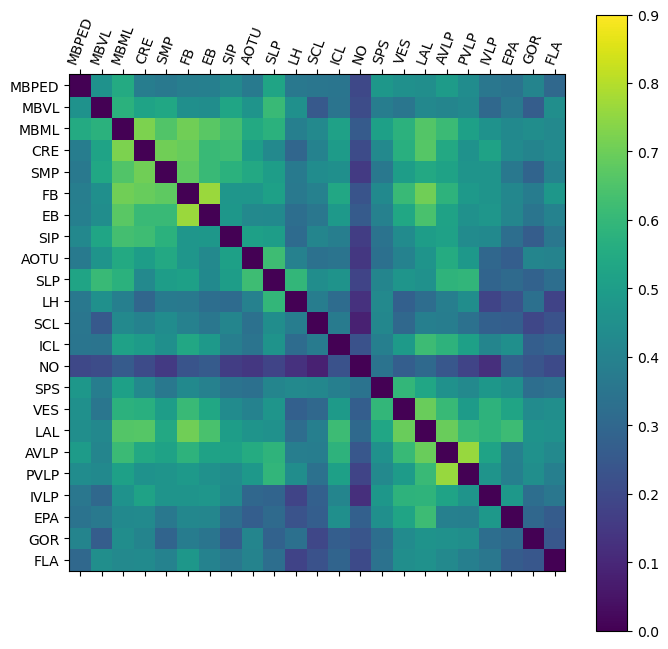

END


In [29]:
''' plot matrix according to community division '''

load_path = path + 'ACh_5HT_average_RS/'
print(load_path)

## region orders according to community division
hierarchy_region = [64, 65, 66, 63, 74, 26, 23, 73, 79, 72, 55, 84, 59, 4, 82, 60, 56, 75, 76, 77, 85, 80, 67]
hierarchy_region_name = ['MBPED', 'MBVL','MBML','CRE','SMP','FB','EB','SIP', 'AOTU','SLP','LH','SCL','ICL','NO', 
                         'SPS', 'VES', 'LAL', 'AVLP', 'PVLP', 'IVLP', 'EPA', 'GOR', 'FLA']


## calculate correlation matrix according to community division
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        pair = (hierarchy_region[i],hierarchy_region[j])
        if pair not in region_similarity_dict.keys():
            pair = (hierarchy_region[j],hierarchy_region[i])
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])

## plot correlation matrix according to community division
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 0.9) 
figure.colorbar(caxes) 
plt.xticks(rotation = 70)
plt.xticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.yticks(rotation = 0)
plt.yticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.savefig(load_path + 'whole_brain_all_regions_similarity_hierarchy2_ACH.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(load_path + 'whole_brain_all_regions_similarity_hierarchy2_ACH_region.npy', hierarchy_region)
np.save(load_path + 'whole_brain_all_regions_similarity_hierarchy2_ACH.npy', similarity)

print("END")

## Generate average 5HT network over 10 5HT-flies

outpath: /0-LLB/New_data/data_analysis_res_deepcad/Ach-all-flies-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/20230429-r5HT1.0-fly1-trans-pre_stimu/
---- processing inputpath:  /0-LLB/New_data/data_analysis_res_deepcad/20230506-r5HT1.0-fly1-trans-pre_stimu/
similarity: (23, 23)


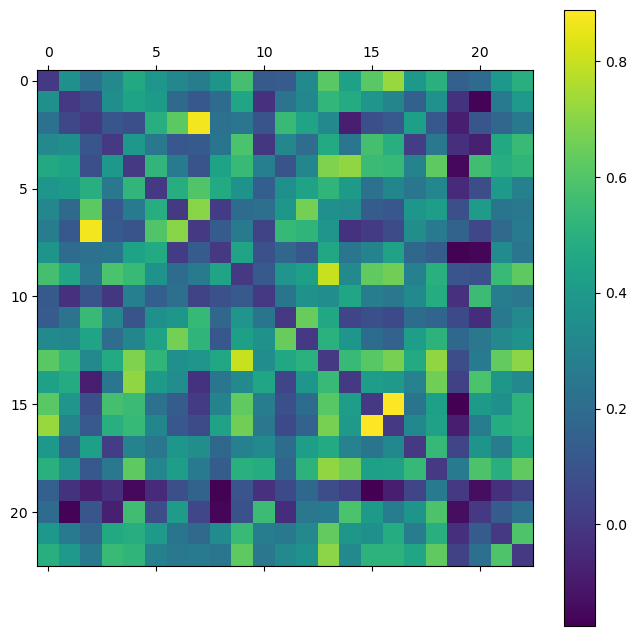

---- Finish saving similarity matrix!


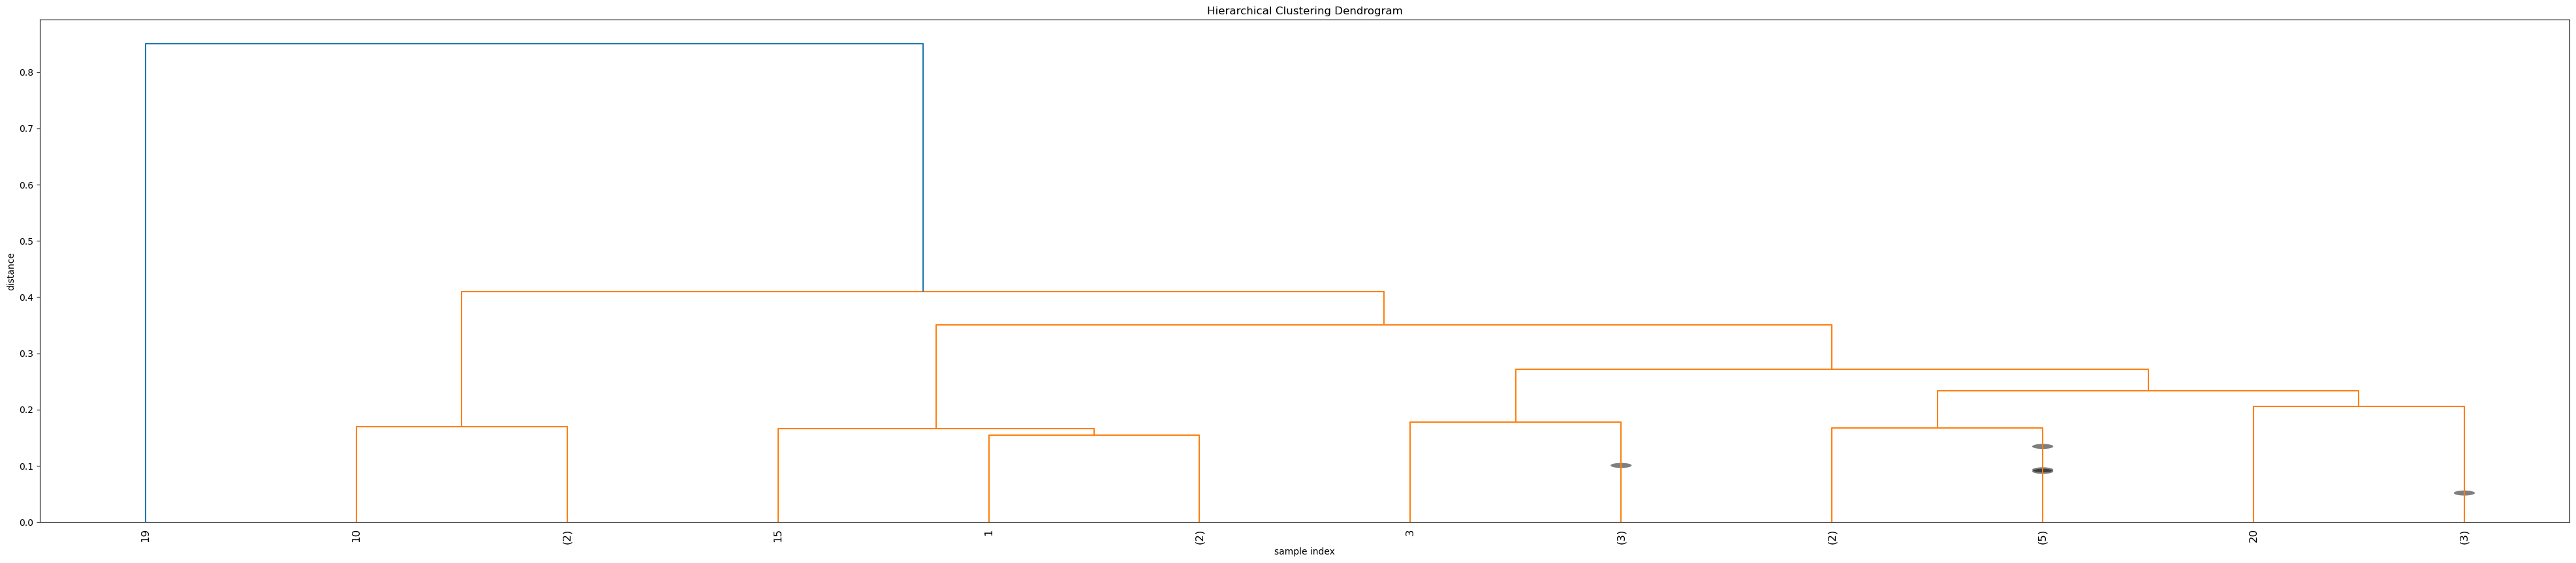

clusters: <class 'numpy.ndarray'> 23 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1]
hierarchy region name: 23 ['MBPED', 'MBVL', 'MBML', 'LH', 'SLP', 'SIP', 'SMP', 'CRE', 'SCL', 'ICL', 'NO', 'EB', 'FB', 'LAL', 'AOTU', 'AVLP', 'PVLP', 'IVLP', 'VES', 'SPS', 'EPA', 'FLA', 'GOR']
hierarchy similarity: (23, 23)


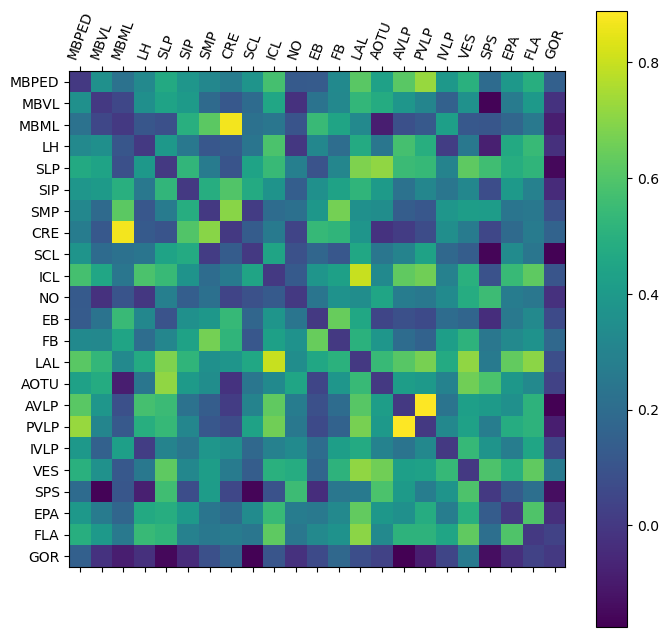

---- Finish saving hierarchy similarity matrix!
END


In [20]:
''' generate average correlation matrix '''

## output path
outpath = path + 'ACh_5HT_average_RS/'
print("outpath:", outpath)

'''
initialization
'''

n_regions = len(focus_regions_0)
region_similarity_dict = {}
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        region_similarity_dict[(focus_regions_0[i],focus_regions_0[j])] = []
region_records_avg_dict = {}
for i in range(n_regions):
    region_records_avg_dict[focus_regions_0[i]] = []
    
'''
process 5HT flies
'''

data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]
focus_regions_1 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,85,67] # brain regions except 82
focus_regions_2 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 80,82
focus_regions_3 = [64,65,66,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # brain regions except 55

for fly_idx in data_index_list:
    inputpath = path + 'flies_5HT/' + fly_idx + '-trans-pre_stimu/'
    print("---- processing inputpath: ", inputpath)
    
    region_records_avg = []
    focus_regions = []
    if fly_idx in ["20230429-r5HT1.0-fly1", "20230516-r5HT1.0-fly4", "20230601-r5HT1.0-fly3", "20230603-r5HT1.0-fly1"]:
        focus_regions = focus_regions_1
    elif fly_idx in ["20230517-r5HT1.0-fly1"]:
        focus_regions = focus_regions_2
    elif fly_idx == "20230601-r5HT1.0-fly1":
        focus_regions = focus_regions_3
    else:
        focus_regions = focus_regions_0

    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        len_max = len(records[0])
        pre_sti = records[:, 4:len_max - 4]      

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        
        region_records_avg.append(pre_sti_avg)
        region_records_avg_dict[region_idx].append(pre_sti_avg)

    ## calculate pearson correlation
    n_regions_new = len(focus_regions)
    for i in range(n_regions_new - 1):
        for j in range(i + 1, n_regions_new):   
            pearson = pearsonr(region_records_avg[i], region_records_avg[j])
            pair = (focus_regions[i], focus_regions[j])
            region_similarity_dict[pair].append(pearson[0])

'''
generate correlation matrix
'''

## calculate correlation
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[(focus_regions_0[i],focus_regions_0[j])])
print("similarity:", similarity.shape)
np.save(outpath + 'whole_brain_all_regions_similarity_5HT.npy', similarity)
   
## plot correlation matrix
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.savefig(outpath + 'whole_brain_all_regions_similarity_5HT.png', dpi = 300, bbox_inches='tight')
plt.show()
print("---- Finish saving similarity matrix!")


'''
calculate hierarchy clustering
'''
region_records_avg_list = []
for i in range(n_regions):
    records_avg = np.mean(region_records_avg_dict[focus_regions_0[i]], axis = 0)
    region_records_avg_list.append(records_avg) 
Z = linkage(region_records_avg_list, 'ward') 
plt.figure(figsize=(50, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()

## clusters
k = 2
clusters = fcluster(Z, k, criterion='maxclust')
print("clusters:", type(clusters), len(clusters), clusters)    
list(enumerate(clusters))
hierarchy_idx = []
hierarchy_region = []
for index_id in range(1,k+1):
    index = [i for i,j in enumerate(clusters) if j == index_id]
    hierarchy_idx.append(index)   
    hierarchy_region += list(np.array(focus_regions_0)[index])

# hierarchy orders
hierarchy_region_name = []
for i in hierarchy_region:
    hierarchy_region_name.append(region_names[i])
hierarchy_idx_list = list(chain(*hierarchy_idx))
print("hierarchy region name:", len(hierarchy_region_name), hierarchy_region_name)

# calculate hierarchy correlation
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        pair = (hierarchy_region[i],hierarchy_region[j])
        if pair not in region_similarity_dict.keys():
            pair = (hierarchy_region[j],hierarchy_region[i])
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])
print("hierarchy similarity:", similarity.shape)

## plot hierarchy correlation matrix
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.xticks(rotation = 70)
plt.xticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.yticks(rotation = 0)
plt.yticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.savefig(outpath + 'whole_brain_all_regions_similarity_hierarchy1_5HT.png', dpi = 300, bbox_inches='tight')
plt.show()
print("---- Finish saving hierarchy similarity matrix!")

hierarchy_idx_dict = {}
for k in range(len(hierarchy_idx)):
    hierarchy_idx_dict[k] = hierarchy_idx[k]
np.save(outpath + 'whole_brain_all_regions_similarity_hierarchy1_5HT_idx.npy', hierarchy_idx_dict)
np.save(outpath + 'whole_brain_all_regions_similarity_hierarchy1_5HT.npy', similarity)

print("END")

In [21]:
''' generate average network and communities '''

## parameters
delete_seg = 0

'''
generate networks
'''

## load data
load_path = path + 'ACh_5HT_average_RS/'
similarity = np.load(load_path + 'whole_brain_all_regions_similarity_5HT.npy')
print("similarity:", similarity.shape)

## collect nodes and edges
n_neurons = len(similarity)
nodes = [i for i in range(n_neurons)]
edges = {}
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):   
        edges[(i,j)] = similarity[i,j]
        
## keep only correlations with high positive values 
weighted_edges_list = []
for v in edges.values():
    weighted_edges_list.append(v)
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
source, target, weight = [], [], []
selected_edges = []
for k,v in edges.items():
    if np.mean(v) < threshold:
        continue
    source.append(int(k[0]))
    target.append(int(k[1]))
    weight.append(np.round(v,4))
    selected_edges.append((int(k[0]), int(k[1]), np.round(v,4)))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(load_path + 'regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_5HT.csv', index=False)

print("END")

similarity: (23, 23)
END


/0-LLB/New_data/data_analysis_res_deepcad/Ach-all-flies-trans-pre_stimu/


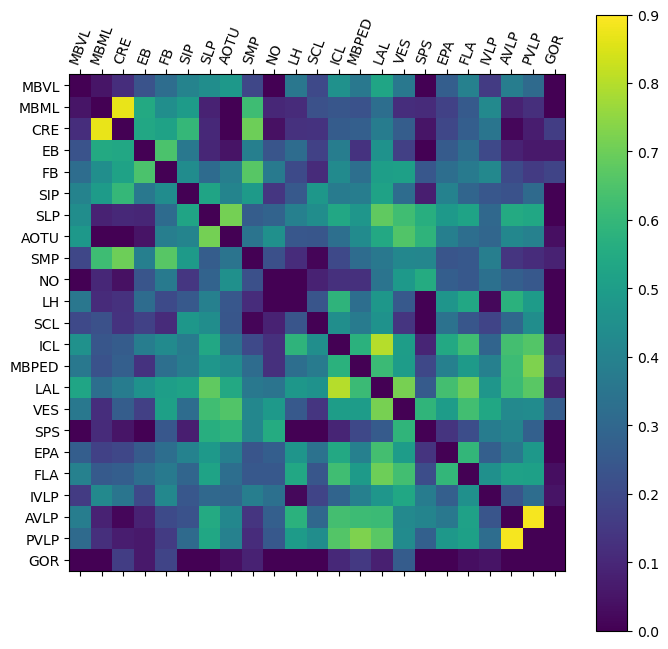

END


In [22]:
''' plot matrix according to community division '''

load_path = path + 'ACh_5HT_average_RS/'
print(load_path)

## region orders according to community division
hierarchy_region = [65, 66, 63, 23, 26, 73, 72,  79, 74, 4, 55, 84, 59, 64, 56, 60, 82, 85, 67, 77, 75, 76,  80]
hierarchy_region_name = ['MBVL', 'MBML', 'CRE', 'EB', 'FB', 'SIP', 'SLP', 'AOTU',  'SMP', 'NO', 'LH', 'SCL', 
                         'ICL', 'MBPED', 'LAL', 'VES', 'SPS', 'EPA', 'FLA', 'IVLP', 'AVLP', 'PVLP', 'GOR']  


## calculate correlation matrix according to community division
similarity = np.zeros((n_regions, n_regions))
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):   
        pair = (hierarchy_region[i],hierarchy_region[j])
        if pair not in region_similarity_dict.keys():
            pair = (hierarchy_region[j],hierarchy_region[i])
        similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])

## plot correlation matrix according to community division
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 0.9) 
figure.colorbar(caxes) 
plt.xticks(rotation = 70)
plt.xticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.yticks(rotation = 0)
plt.yticks(range(len(hierarchy_region)), hierarchy_region_name)
plt.savefig(load_path + 'whole_brain_all_regions_similarity_hierarchy2_5HT.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(load_path + 'whole_brain_all_regions_similarity_hierarchy2_5HT_region.npy', hierarchy_region)
np.save(load_path + 'whole_brain_all_regions_similarity_hierarchy2_5HT.npy', similarity)

print("END")